# Project:

In [1]:
# 9. Airbnb Dynamic Pricing Recommendation Engine
# Objective: Analyze historical Airbnb data to suggest optimal pricing based on location, season, and
# listing quality.
# Tools: Python, Tableau, Excel

# Mini Guide:
# Analyze pricing by city, property type, reviews
# Run regression model to find pricing predictors
# Create dashboard with price suggestion slider

# Deliverables:
# Tableau dashboard with filters
# Python pricing engine script
# Final PDF with suggestions

## 1.made virual environment

## 2.Installed the required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xg
import sklearn
import tensorflow as tf

## 3.Importing the dataset into pandas

In [2]:
df=pd.read_csv("train/train.csv")
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


# 4.EDA

In [3]:
df_columns=df.columns
df_columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37909 entries, 0 to 37908
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   log_price             37909 non-null  float64
 1   property_type         37909 non-null  int64  
 2   room_type             37909 non-null  int64  
 3   accommodates          37909 non-null  int64  
 4   bathrooms             37909 non-null  float64
 5   cancellation_policy   37909 non-null  int64  
 6   cleaning_fee          37909 non-null  int64  
 7   instant_bookable      37909 non-null  int64  
 8   number_of_reviews     37909 non-null  int64  
 9   review_scores_rating  37909 non-null  float64
 10  bedrooms              37909 non-null  float64
 11  beds                  37909 non-null  float64
 12  Chicago               37909 non-null  int64  
 13  DC                    37909 non-null  int64  
 14  LA                    37909 non-null  int64  
 15  NYC                

## a) Checking for null values

In [4]:
print(df.isnull().sum())
print(f"Total Null Values: {df.isnull().sum().sum()}")

id                            0
log_price                     0
property_type                 0
room_type                     0
amenities                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
description                   0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
name                          0
neighbourhood              6872
number_of_reviews             0
review_scores_rating      16722
thumbnail_url              8216
zipcode                     966
bedrooms                     91
beds                        131
dtype: int64
Total Null Values: 83752


## b) Removing or dropping null values

In [5]:
df=df.dropna()
print(f"Total Null Values: {df.isnull().sum().sum()}")

Total Null Values: 0


## c) Removing outliers from log_price (Target variable)

<Axes: ylabel='log_price'>

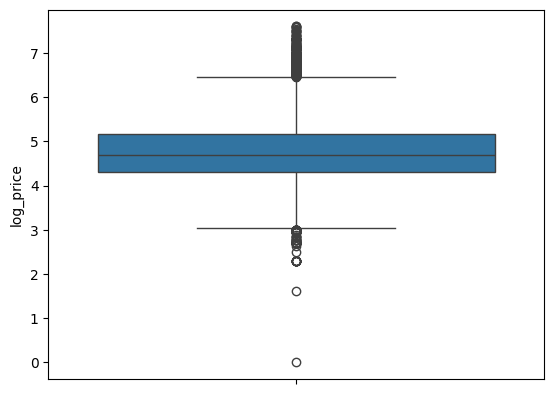

In [6]:
sns.boxplot(data=df["log_price"])

## Removing outliers from log_price

In [10]:
q1 = df["log_price"].quantile(0.25)
q3 = df["log_price"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df = df[(df["log_price"] >= lower_bound) & (df["log_price"] <= upper_bound)]
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
5,12422935,4.442651,Apartment,Private room,"{TV,""Wireless Internet"",Heating,""Smoke detecto...",2,1.0,Real Bed,strict,True,...,37.753164,-122.429526,Comfort Suite San Francisco,Noe Valley,3,100.0,https://a0.muscache.com/im/pictures/82509143-4...,94131,1.0,1.0
7,13971273,4.787492,Condominium,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Wheelchair...",2,1.0,Real Bed,moderate,True,...,34.046737,-118.260439,"Near LA Live, Staple's. Starbucks inside. OWN ...",Downtown,9,93.0,https://a0.muscache.com/im/pictures/61bd05d5-c...,90015,1.0,1.0
8,180792,4.787492,House,Private room,"{TV,""Cable TV"",""Wireless Internet"",""Pets live ...",2,1.0,Real Bed,moderate,True,...,37.781128,-122.501095,Cozy Garden Studio - Private Entry,Richmond District,159,99.0,https://a0.muscache.com/im/pictures/0ed6c128-7...,94121,1.0,1.0


In [11]:
df.room_type.value_counts()

room_type
Entire home/apt    21016
Private room       16010
Shared room          883
Name: count, dtype: int64

<Axes: ylabel='log_price'>

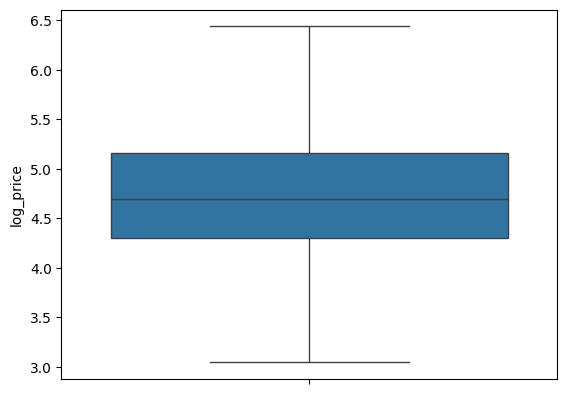

In [12]:
sns.boxplot(data=df["log_price"])

## d) Dropping the columns which are not required.

In [13]:
df.drop(columns={'amenities','bed_type','description',
       'last_review','name', 'neighbourhood','zipcode','thumbnail_url','host_has_profile_pic', 'host_identity_verified', 'host_response_rate','first_review'},inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37909 entries, 1 to 74110
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    37909 non-null  int64  
 1   log_price             37909 non-null  float64
 2   property_type         37909 non-null  object 
 3   room_type             37909 non-null  object 
 4   accommodates          37909 non-null  int64  
 5   bathrooms             37909 non-null  float64
 6   cancellation_policy   37909 non-null  object 
 7   cleaning_fee          37909 non-null  bool   
 8   city                  37909 non-null  object 
 9   host_since            37909 non-null  object 
 10  instant_bookable      37909 non-null  object 
 11  latitude              37909 non-null  float64
 12  longitude             37909 non-null  float64
 13  number_of_reviews     37909 non-null  int64  
 14  review_scores_rating  37909 non-null  float64
 15  bedrooms              37

## e) Checking the correlation of log_price with other dependable variables

In [15]:
df.corr(numeric_only=True)["log_price"]

id                     -0.008140
log_price               1.000000
accommodates            0.553487
bathrooms               0.238699
cleaning_fee            0.167707
latitude                0.007001
longitude              -0.053350
number_of_reviews      -0.001213
review_scores_rating    0.071382
bedrooms                0.434798
beds                    0.438267
Name: log_price, dtype: float64

## f) Replace the categorical variables with numerical values

### Replacing cancellation policy columns with numerical data

In [16]:
df.cancellation_policy.unique()


array(['strict', 'moderate', 'flexible', 'super_strict_30',
       'super_strict_60'], dtype=object)

In [17]:
data_map={'flexible':4,'moderate':3,'strict':1,'super_strict_30':0,'super_strict_60':0}
df['cancellation_policy'] = df['cancellation_policy'].map(data_map)
df.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,city,host_since,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
1,6304928,5.129899,Apartment,Entire home/apt,7,1.0,1,True,NYC,2017-06-19,t,40.766115,-73.989040,6,93.0,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,5,1.0,3,True,NYC,2016-10-25,t,40.808110,-73.943756,10,92.0,1.0,3.0
5,12422935,4.442651,Apartment,Private room,2,1.0,1,True,SF,2017-06-07,t,37.753164,-122.429526,3,100.0,1.0,1.0
7,13971273,4.787492,Condominium,Entire home/apt,2,1.0,3,True,LA,2013-05-18,f,34.046737,-118.260439,9,93.0,1.0,1.0
8,180792,4.787492,House,Private room,2,1.0,3,True,SF,2015-06-04,f,37.781128,-122.501095,159,99.0,1.0,1.0


### Replacing property_type column with numerical data

In [18]:
df.property_type.unique()

array(['Apartment', 'Condominium', 'House', 'Townhouse', 'Loft', 'Hostel',
       'Guest suite', 'Bungalow', 'Guesthouse', 'Dorm', 'Other',
       'Bed & Breakfast', 'Boutique hotel', 'Villa', 'Timeshare',
       'In-law', 'Camper/RV', 'Castle', 'Boat', 'Cabin', 'Treehouse',
       'Serviced apartment', 'Tipi', 'Hut', 'Vacation home', 'Tent',
       'Chalet', 'Yurt', 'Earth House', 'Train', 'Cave'], dtype=object)

In [19]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['property_type'] = le.fit_transform(df['property_type'])
df.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,city,host_since,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
1,6304928,5.129899,0,Entire home/apt,7,1.0,1,True,NYC,2017-06-19,t,40.766115,-73.989040,6,93.0,3.0,3.0
2,7919400,4.976734,0,Entire home/apt,5,1.0,3,True,NYC,2016-10-25,t,40.808110,-73.943756,10,92.0,1.0,3.0
5,12422935,4.442651,0,Private room,2,1.0,1,True,SF,2017-06-07,t,37.753164,-122.429526,3,100.0,1.0,1.0
7,13971273,4.787492,10,Entire home/apt,2,1.0,3,True,LA,2013-05-18,f,34.046737,-118.260439,9,93.0,1.0,1.0
8,180792,4.787492,16,Private room,2,1.0,3,True,SF,2015-06-04,f,37.781128,-122.501095,159,99.0,1.0,1.0


### Replacing instant_bookable column with numerical data

In [20]:
data_map={'t':1,'f':0}
df["instant_bookable"] = df["instant_bookable"].map(data_map)
df.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,city,host_since,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
1,6304928,5.129899,0,Entire home/apt,7,1.0,1,True,NYC,2017-06-19,1,40.766115,-73.989040,6,93.0,3.0,3.0
2,7919400,4.976734,0,Entire home/apt,5,1.0,3,True,NYC,2016-10-25,1,40.808110,-73.943756,10,92.0,1.0,3.0
5,12422935,4.442651,0,Private room,2,1.0,1,True,SF,2017-06-07,1,37.753164,-122.429526,3,100.0,1.0,1.0
7,13971273,4.787492,10,Entire home/apt,2,1.0,3,True,LA,2013-05-18,0,34.046737,-118.260439,9,93.0,1.0,1.0
8,180792,4.787492,16,Private room,2,1.0,3,True,SF,2015-06-04,0,37.781128,-122.501095,159,99.0,1.0,1.0


In [21]:
df.fillna(0,inplace=True)
df.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,city,host_since,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
1,6304928,5.129899,0,Entire home/apt,7,1.0,1,True,NYC,2017-06-19,1,40.766115,-73.989040,6,93.0,3.0,3.0
2,7919400,4.976734,0,Entire home/apt,5,1.0,3,True,NYC,2016-10-25,1,40.808110,-73.943756,10,92.0,1.0,3.0
5,12422935,4.442651,0,Private room,2,1.0,1,True,SF,2017-06-07,1,37.753164,-122.429526,3,100.0,1.0,1.0
7,13971273,4.787492,10,Entire home/apt,2,1.0,3,True,LA,2013-05-18,0,34.046737,-118.260439,9,93.0,1.0,1.0
8,180792,4.787492,16,Private room,2,1.0,3,True,SF,2015-06-04,0,37.781128,-122.501095,159,99.0,1.0,1.0


### Replacing cleaning_fee column with numerical data

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["cleaning_fee"] = le.fit_transform(df["cleaning_fee"])
df.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,city,host_since,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
1,6304928,5.129899,0,Entire home/apt,7,1.0,1,1,NYC,2017-06-19,1,40.766115,-73.989040,6,93.0,3.0,3.0
2,7919400,4.976734,0,Entire home/apt,5,1.0,3,1,NYC,2016-10-25,1,40.808110,-73.943756,10,92.0,1.0,3.0
5,12422935,4.442651,0,Private room,2,1.0,1,1,SF,2017-06-07,1,37.753164,-122.429526,3,100.0,1.0,1.0
7,13971273,4.787492,10,Entire home/apt,2,1.0,3,1,LA,2013-05-18,0,34.046737,-118.260439,9,93.0,1.0,1.0
8,180792,4.787492,16,Private room,2,1.0,3,1,SF,2015-06-04,0,37.781128,-122.501095,159,99.0,1.0,1.0


### Replacing the values in the city column with 0 and 1

In [23]:
df=pd.get_dummies(df,columns=["city"],drop_first=True,dtype=int)
df.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,host_since,instant_bookable,...,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,city_Chicago,city_DC,city_LA,city_NYC,city_SF
1,6304928,5.129899,0,Entire home/apt,7,1.0,1,1,2017-06-19,1,...,-73.989040,6,93.0,3.0,3.0,0,0,0,1,0
2,7919400,4.976734,0,Entire home/apt,5,1.0,3,1,2016-10-25,1,...,-73.943756,10,92.0,1.0,3.0,0,0,0,1,0
5,12422935,4.442651,0,Private room,2,1.0,1,1,2017-06-07,1,...,-122.429526,3,100.0,1.0,1.0,0,0,0,0,1
7,13971273,4.787492,10,Entire home/apt,2,1.0,3,1,2013-05-18,0,...,-118.260439,9,93.0,1.0,1.0,0,0,1,0,0
8,180792,4.787492,16,Private room,2,1.0,3,1,2015-06-04,0,...,-122.501095,159,99.0,1.0,1.0,0,0,0,0,1


## Removing the city prefix from the column name

In [24]:
df.columns=df.columns.str.replace('city_', '',regex=True)
df.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,host_since,instant_bookable,...,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,Chicago,DC,LA,NYC,SF
1,6304928,5.129899,0,Entire home/apt,7,1.0,1,1,2017-06-19,1,...,-73.989040,6,93.0,3.0,3.0,0,0,0,1,0
2,7919400,4.976734,0,Entire home/apt,5,1.0,3,1,2016-10-25,1,...,-73.943756,10,92.0,1.0,3.0,0,0,0,1,0
5,12422935,4.442651,0,Private room,2,1.0,1,1,2017-06-07,1,...,-122.429526,3,100.0,1.0,1.0,0,0,0,0,1
7,13971273,4.787492,10,Entire home/apt,2,1.0,3,1,2013-05-18,0,...,-118.260439,9,93.0,1.0,1.0,0,0,1,0,0
8,180792,4.787492,16,Private room,2,1.0,3,1,2015-06-04,0,...,-122.501095,159,99.0,1.0,1.0,0,0,0,0,1


## Replacing the room_type with numerical data

In [25]:
df.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [26]:
map_data={'Entire home/apt':2,'Private room':1,'Shared room':0}
df['room_type'] = df['room_type'].map(map_data)

In [27]:
df.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'cancellation_policy', 'cleaning_fee', 'host_since',
       'instant_bookable', 'latitude', 'longitude', 'number_of_reviews',
       'review_scores_rating', 'bedrooms', 'beds', 'Chicago', 'DC', 'LA',
       'NYC', 'SF'],
      dtype='object')

In [28]:
df.drop(columns=['id','host_since'],inplace=True)
df.head()

,log_price,property_type,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds,Chicago,DC,LA,NYC,SF
1,5.129899,0,2,7,1.0,1,1,1,40.766115,-73.989040,6,93.0,3.0,3.0,0,0,0,1,0
2,4.976734,0,2,5,1.0,3,1,1,40.808110,-73.943756,10,92.0,1.0,3.0,0,0,0,1,0
5,4.442651,0,1,2,1.0,1,1,1,37.753164,-122.429526,3,100.0,1.0,1.0,0,0,0,0,1
7,4.787492,10,2,2,1.0,3,1,0,34.046737,-118.260439,9,93.0,1.0,1.0,0,0,1,0,0
8,4.787492,16,1,2,1.0,3,1,0,37.781128,-122.501095,159,99.0,1.0,1.0,0,0,0,0,1


## Checking the data types for each column for model training

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37909 entries, 1 to 74110
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   log_price             37909 non-null  float64
 1   property_type         37909 non-null  int64  
 2   room_type             37909 non-null  int64  
 3   accommodates          37909 non-null  int64  
 4   bathrooms             37909 non-null  float64
 5   cancellation_policy   37909 non-null  int64  
 6   cleaning_fee          37909 non-null  int64  
 7   instant_bookable      37909 non-null  int64  
 8   latitude              37909 non-null  float64
 9   longitude             37909 non-null  float64
 10  number_of_reviews     37909 non-null  int64  
 11  review_scores_rating  37909 non-null  float64
 12  bedrooms              37909 non-null  float64
 13  beds                  37909 non-null  float64
 14  Chicago               37909 non-null  int64  
 15  DC                    37

## Since the location is already mentioned, there is no need for latitude,longitude

In [30]:
df.drop(columns=['latitude','longitude'],inplace=True)
df.head()

,log_price,property_type,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,beds,Chicago,DC,LA,NYC,SF
1,5.129899,0,2,7,1.0,1,1,1,6,93.0,3.0,3.0,0,0,0,1,0
2,4.976734,0,2,5,1.0,3,1,1,10,92.0,1.0,3.0,0,0,0,1,0
5,4.442651,0,1,2,1.0,1,1,1,3,100.0,1.0,1.0,0,0,0,0,1
7,4.787492,10,2,2,1.0,3,1,0,9,93.0,1.0,1.0,0,0,1,0,0
8,4.787492,16,1,2,1.0,3,1,0,159,99.0,1.0,1.0,0,0,0,0,1


In [31]:
## saving the cleaned data
df.to_csv("train/cleaned_train.csv",index=False)

In [33]:
df=pd.read_csv("train/cleaned_train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37909 entries, 0 to 37908
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   log_price             37909 non-null  float64
 1   property_type         37909 non-null  int64  
 2   room_type             37909 non-null  int64  
 3   accommodates          37909 non-null  int64  
 4   bathrooms             37909 non-null  float64
 5   cancellation_policy   37909 non-null  int64  
 6   cleaning_fee          37909 non-null  int64  
 7   instant_bookable      37909 non-null  int64  
 8   number_of_reviews     37909 non-null  int64  
 9   review_scores_rating  37909 non-null  float64
 10  bedrooms              37909 non-null  float64
 11  beds                  37909 non-null  float64
 12  Chicago               37909 non-null  int64  
 13  DC                    37909 non-null  int64  
 14  LA                    37909 non-null  int64  
 15  NYC                

In [34]:
df.drop(columns=['number_of_reviews'],inplace=True)

## Normalizing number_of_reviews

In [35]:
df["review_scores_rating"]=df["review_scores_rating"]/max(df["review_scores_rating"])

In [36]:
df.corr(numeric_only=True)["log_price"]
df.corr(numeric_only=True)["log_price"].sort_values(ascending=False)

log_price               1.000000
room_type               0.652710
accommodates            0.553487
beds                    0.438267
bedrooms                0.434798
bathrooms               0.238699
SF                      0.185518
cleaning_fee            0.167707
review_scores_rating    0.071382
DC                     -0.010844
instant_bookable       -0.029095
property_type          -0.030515
NYC                    -0.037475
LA                     -0.059959
Chicago                -0.082581
cancellation_policy    -0.179486
Name: log_price, dtype: float64

## There is a better relationship between log_price with the following features: (after converting from categorical to numerical)
### room_type               0.652710
### accommodates            0.553487
### beds                    0.438267
### bedrooms                0.434798
### bathrooms               0.238699
### SF                      0.185518
### cleaning_fee            0.167707
### review_scores_rating    0.071382

In [3]:
df=pd.read_csv("train/cleaned_train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37909 entries, 0 to 37908
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   log_price             37909 non-null  float64
 1   property_type         37909 non-null  int64  
 2   room_type             37909 non-null  int64  
 3   accommodates          37909 non-null  int64  
 4   bathrooms             37909 non-null  float64
 5   cancellation_policy   37909 non-null  int64  
 6   cleaning_fee          37909 non-null  int64  
 7   instant_bookable      37909 non-null  int64  
 8   number_of_reviews     37909 non-null  int64  
 9   review_scores_rating  37909 non-null  float64
 10  bedrooms              37909 non-null  float64
 11  beds                  37909 non-null  float64
 12  Chicago               37909 non-null  int64  
 13  DC                    37909 non-null  int64  
 14  LA                    37909 non-null  int64  
 15  NYC                

In [4]:
X=df.drop(columns=["log_price"])
y=df["log_price"]
X.head()

,property_type,room_type,accommodates,bathrooms,cancellation_policy,cleaning_fee,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,beds,Chicago,DC,LA,NYC,SF
0,0,2,7,1.0,1,1,1,6,93.0,3.0,3.0,0,0,0,1,0
1,0,2,5,1.0,3,1,1,10,92.0,1.0,3.0,0,0,0,1,0
2,0,1,2,1.0,1,1,1,3,100.0,1.0,1.0,0,0,0,0,1
3,10,2,2,1.0,3,1,0,9,93.0,1.0,1.0,0,0,1,0,0
4,16,1,2,1.0,3,1,0,159,99.0,1.0,1.0,0,0,0,0,1


In [38]:
print(X.shape)
print(y.shape)

(37909, 15)
(37909,)


In [39]:
y.head()

0    5.129899
1    4.976734
2    4.442651
3    4.787492
4    4.787492
Name: log_price, dtype: float64

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)

(30327, 16) (30327,)


## 5. Trying different ML models for model building

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import joblib

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror')
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    joblib.dump(model, f"{name}.joblib")
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    results.append((name,r2))


results_df = pd.DataFrame(results, columns=['Model','R2 Score'])
print(results_df.sort_values(by='R2 Score'))   


               Model  R2 Score
0  Linear Regression  0.578555
1      Random Forest  0.579940
2            XGBoost  0.621328


## XGBoost has given more accuracy/R2 score. Saving all models.

### 6. Trying to build a model with Deep Neural Networks.

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = keras.models.load_model("model.keras")

# model=Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f},Test accuracy: {test_accuracy:.4f}")

# Saving the model
model.save("model.keras")
# printing the model size
import os
size_of_model = os.path.getsize("model.keras")/(1024 * 1024)  # size in MB
print("Model size in MB:", size_of_model)

f:\MCA\Intern\elevateLabs\5052025-Project\AirbnbDynamicPricingRecommendationEngine\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 32)             │            6

 Total params: 901,826 (3.44 MB)

 Trainable params: 901,826 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
759/759 ━━━━━━━━━━━━━━━━━━━━ 67s 51ms/step - loss: 3.0673 - mae: 0.9816 - val_loss: 0.1759 - val_mae: 0.3212
Epoch 2/200
759/759 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - loss: 0.1037 - mae: 0.2457 - val_loss: 0.1850 - val_mae: 0.3350
Epoch 3/200
759/759 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - loss: 0.1071 - mae: 0.2509 - val_loss: 0.2183 - val_mae: 0.3651
Epoch 4/200
759/759 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - loss: 0.1184 - mae: 0.2659 - val_loss: 0.1987 - val_mae: 0.3468
Epoch 5/200
759/759 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 0.1041 - mae: 0.2468 - val_loss: 0.1747 - val_mae: 0.3241
Epoch 6/200
759/759 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - loss: 0.1127 - mae: 0.2586 - val_loss: 0.1725 - val_mae: 0.3213
Epoch 7/200
759/759 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 0.1240 - mae: 0.2715 - val_loss: 0.1729 - val_mae: 0.3212
Epoch 8/200
759/759 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - loss: 0.1034 - mae: 0.2472 - val_loss: 0.2058 - val_mae: 0.3530
Epoch 9/200
759/759 ━━━━━━━━━━━━

## loading the model

In [42]:
import keras
model = keras.models.load_model("model.keras")
y_pred = model.predict(X_test)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f},Test accuracy: {test_accuracy:.4f}")

237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1665 - mae: 0.3156
Test loss: 0.1688,Test accuracy: 0.3182


### Loading the saved XGBoost model for rechecking

In [9]:
from joblib import dump, load
from sklearn.metrics import mean_squared_error, r2_score

model = load("XGBoost.joblib")
y_pred = model.predict(X_test)

# Calculate test loss (mean squared error)
test_loss = mean_squared_error(y_test, y_pred)

# Calculate test accuracy (R2 score)
test_accuracy = r2_score(y_test, y_pred)

print(f"Test loss (MSE): {test_loss:.4f}, Test accuracy (R2 score): {test_accuracy:.4f}")

Test loss (MSE): 0.1409, Test accuracy (R2 score): 0.6213
